<a href="https://colab.research.google.com/github/NUELBUNDI/NLP-using-Python/blob/master/Final_Term_Paper_Scripts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### <u>TEXT AND UNSTRUCTURED DATA ANALYTICS- TERM PAPER SCRIPTS </u>
#### LEE BUNDI - STUDENT NO : 102586

#### Import Packages

In [ ]:
%%time

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import PorterStemmer
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import wordnet

import spacy
import re
import sys
from bs4 import BeautifulSoup
import unicodedata
import string

import gensim
import gensim.downloader as gensim_api
import gensim.downloader as api


tokenizer = ToktokTokenizer()
stopword_list = nltk.corpus.stopwords.words('english')
# nlp = gensim_api.load("glove-wiki-gigaword-300")


import warnings
warnings.filterwarnings('ignore')

Wall time: 16.5 s


**Load the data and get the shape of the data**


In [ ]:
%%time

data= pd.read_csv('hate_data.csv',usecols=['label','tweet'])

rows, columns=data.shape
print(f'Number of Rows: {rows}\nNumber of Columns: {columns}')


Number of Rows: 56745
Number of Columns: 2
Wall time: 117 ms


In [ ]:
# Sample of the data

data.sample(3)

,label,tweet
42587,1,I know a lot of using ass hoes that just want ...
24661,0,@user ðððððððððð...
36291,1,"@Of_Angelis yep, which is messier/more dangero..."


In [ ]:
# Rename the columns

data.rename(columns={'label':'target_value','tweet':'comment_text'},inplace=True)

**Plot the Distribution of the Target Features**

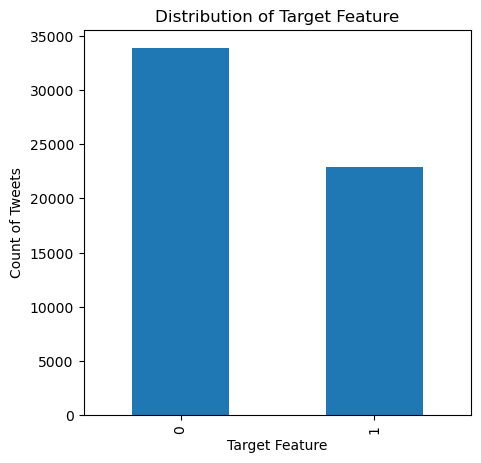

In [ ]:

plt.figure(figsize=(5,5))
data['target_value'].value_counts().plot(kind='bar')
plt.ylabel('Count of Tweets')
plt.xlabel('Target Feature')
plt.title('Distribution of Target Feature')
plt.savefig('fig.png')
plt.show()
plt.close()


**Clean Functions**

In [ ]:
%%time

def remove_repeated_characters(text):
    return re.sub(r'(.)\1+', r'\1', text)

def remove_digits(text):
    text=''.join([c for c in text if c not in string.digits])
    return text

def text_cleaning(text, flag_stem= False, flag_lem=False):
    
    lst_stopwords = nltk.corpus.stopwords.words("english")    #stopwords
    
    soup = BeautifulSoup(text, 'html.parser')
    [s.extract() for s in soup(['iframe', 'script'])]
    stripped_text = soup.get_text()
    stripped_text = re.sub('r[\r|\n|\r\n]+','\n',stripped_text)
    
    text=' '.join(re.sub("(#[A-Za-z0-9]+)|(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",text).split())
    
    text= re.sub(r'[^\w\s]','', str(text).lower().strip())   #Remove punctuations, lowercase , space
    
    text=re.sub(r'amp', '', text).strip()   #remove amp
    
    text=re.sub(r'rt', '', text).strip()    #remove rt
    
    list_text= text.split()    #tokenize the text
    
    #Removing Accented Character
    
    list_text2=[]
    for word in list_text:
        text=unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        list_text2.append(text)    
    list_text=list_text2
    
    
    list_text=[ word for word in list_text if word not in lst_stopwords]  #remove the stop words
    
      
    #Stemming
    if flag_stem==True:
        ps= nltk.porter.PorterStemmer()
        list_text=[ps.stem(word) for word in list_text]
        
    #lemmatization
    if flag_lem==True:
        lem= nltk.stem.wordnet.WordNetLemmatizer()
        list_text=[lem.lemmatize(word) for word in list_text]   

    
    text= ' '.join(list_text)
    
    return text

Wall time: 0 ns


In [ ]:
%%time

# Apply the clean Functions on Data

data['clean_tweet']= data['comment_text'].apply(lambda x : text_cleaning(x,flag_stem=True,flag_lem=True,))

data['clean_tweet']= data['clean_tweet'].apply(lambda x : remove_digits(x))

Wall time: 37.8 s


__Check The Most Frequent Words__.

In [ ]:
%%time

# Check the most 50 common words 

from collections import Counter
cnt = Counter()

for text in data['clean_tweet'].values:
    for word in text.split():
        cnt[word] += 1
        
cnt.most_common(50)

Wall time: 248 ms


[('bitch', 11527),
 ('hoe', 4371),
 ('like', 3905),
 ('u', 3161),
 ('day', 3056),
 ('get', 3037),
 ('fuck', 2466),
 ('love', 2340),
 ('pussi', 2288),
 ('nigga', 2074),
 ('go', 2059),
 ('happi', 1926),
 ('got', 1832),
 ('time', 1723),
 ('make', 1680),
 ('as', 1663),
 ('one', 1598),
 ('want', 1531),
 ('look', 1483),
 ('shit', 1432),
 ('know', 1384),
 ('see', 1379),
 ('good', 1352),
 ('peopl', 1259),
 ('lol', 1259),
 ('today', 1253),
 ('new', 1226),
 ('thank', 1212),
 ('need', 1200),
 ('trash', 1178),
 ('take', 1124),
 ('say', 1119),
 ('come', 1082),
 ('girl', 1060),
 ('life', 1055),
 ('think', 1040),
 ('feel', 1013),
 ('back', 935),
 ('realli', 891),
 ('work', 872),
 ('call', 862),
 ('never', 858),
 ('man', 844),
 ('right', 819),
 ('let', 813),
 ('even', 812),
 ('still', 805),
 ('way', 799),
 ('wait', 795),
 ('talk', 768)]

**Functions to Remove The Most Frequent Words**

In [ ]:
from nltk.tokenize import sent_tokenize, word_tokenize

def multiple_word_remove_func(text, words_2_remove_list):
    
    words_to_remove_list = words_2_remove_list
    
    words = word_tokenize(text)
    text = ' '.join([word for word in words if word not in words_to_remove_list])
    return text


In [ ]:
list_of_word_to_remove=['u','get','like','day','lol','na','gt','go','yo','one','got','ta']

data['clean_tweet']= data['clean_tweet'].apply(lambda x : multiple_word_remove_func(x,list_of_word_to_remove))

In [ ]:
data.head(2)

,target_value,comment_text,clean_tweet
0,0,@user when a father is dysfunctional and is s...,father dysfunct selfish drag kid dysfunct
1,0,@user @user thanks for #lyft credit i can't us...,thank credit use caus offer wheelchair van pdx


In [ ]:
# Example of the clean dataset

number=1234

print(data['comment_text'].iloc[number],"---\n\n",data['clean_tweet'].iloc[number]\
      ,'Label----',data['target_value'].iloc[number])

the oprah winfrey show 20th anniversary collection came in today! 17 hours of footage! i can't wait!!   ---

 oprah winfrey show th anniversari collect came today hour footag wait Label---- 0


### 3.EDA and Sentiment Analysis

1.  Polarity/sentiment Analysis
2.  Unigram and Bigram and Most Frequent Words
3.  Tags Detection 
4.  Word Map
5.  Topic Modelling

### 3.1 Sentiment Analysis

In [ ]:
%%time

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob

vader_sentiment=SentimentIntensityAnalyzer()

def vader_sentiment_scores(text):
    score = vader_sentiment.polarity_scores(text)
    return score['compound']


data["sen_score_blob"] = data['clean_tweet'].apply(lambda x:TextBlob(x).sentiment.polarity)
data['sen_score_vader']= data['clean_tweet'].apply(lambda x : vader_sentiment_scores(x))



Wall time: 10.1 s


**Distribution of Sentiments In The Tweets**

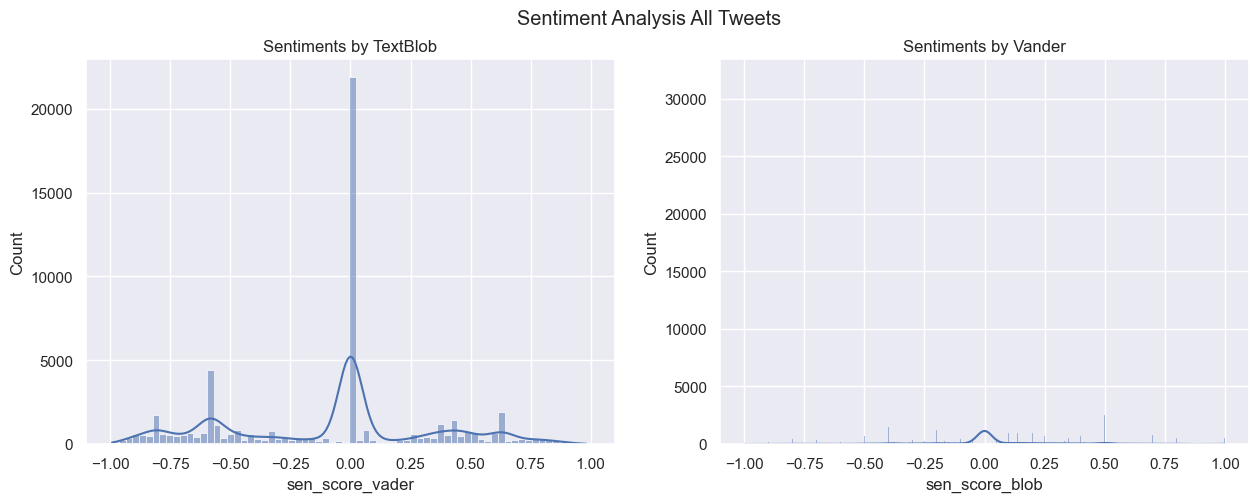

Wall time: 2.31 s


In [ ]:
%%time

sns.set()

figure, axes = plt.subplots(1, 2, sharex=True, figsize=(15,5))
figure.suptitle('Sentiment Analysis All Tweets')

sns.histplot(ax= axes[0] ,data=data, x='sen_score_vader',kde=True)
sns.histplot(ax= axes[1],data=data, x='sen_score_blob',kde=True)
axes[0].set_title('Sentiments by TextBlob')
axes[1].set_title('Sentiments by Vander')
plt.show()

**Distribution of Sentiments In The Tweets That Have NO Hate**

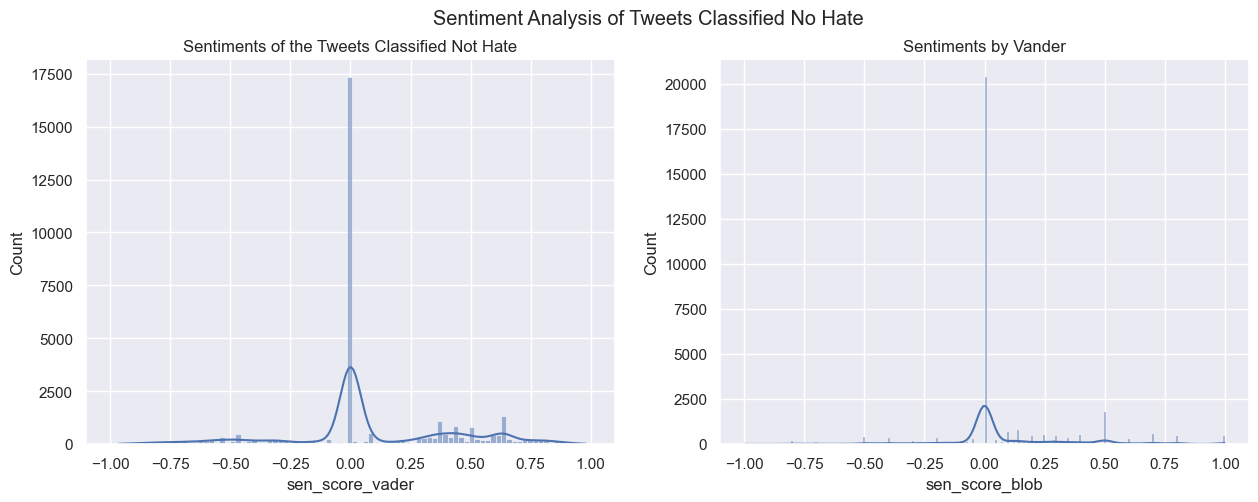

Wall time: 1.44 s


In [ ]:
%%time

data_clean=data[data['target_value']==0]
sns.set()

figure, axes = plt.subplots(1, 2, sharex=True, figsize=(15,5))
figure.suptitle('Sentiment Analysis of Tweets Classified No Hate')

sns.histplot(ax= axes[0] ,data=data_clean, x='sen_score_vader',kde=True)
sns.histplot(ax= axes[1],data=data_clean, x='sen_score_blob',kde=True)
axes[0].set_title('Sentiments of the Tweets Classified Not Hate')
axes[1].set_title('Sentiments by Vander')
plt.show()

**Distribution of Sentiments In The Tweets That Have Hate**

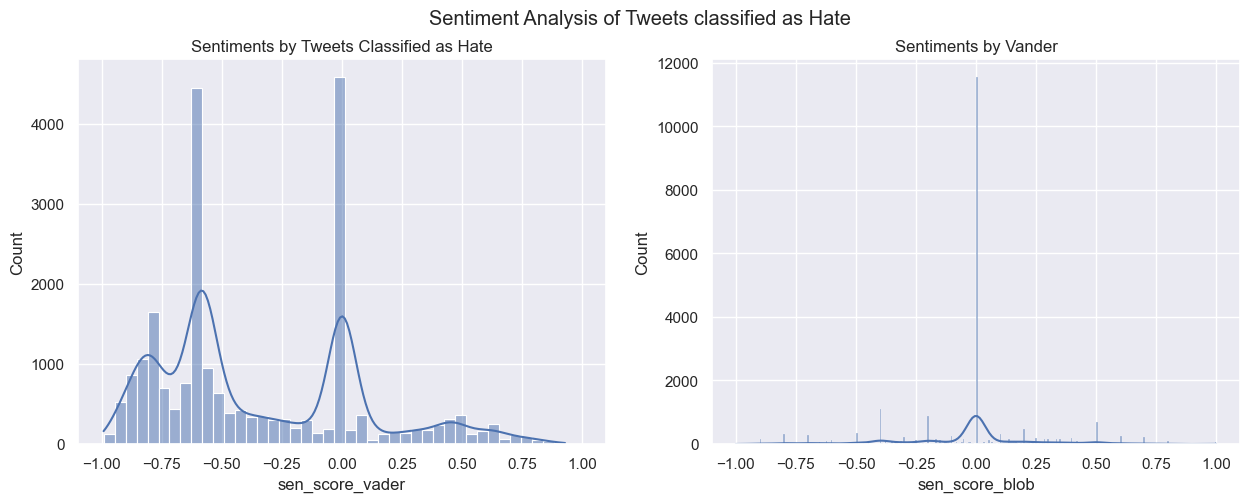

Wall time: 1.1 s


In [ ]:
%%time

data_hate=data[data['target_value']==1]
sns.set()

figure, axes = plt.subplots(1, 2, sharex=True, figsize=(15,5))
figure.suptitle('Sentiment Analysis of Tweets classified as Hate')

sns.histplot(ax= axes[0] ,data=data_hate, x='sen_score_vader',kde=True)
sns.histplot(ax= axes[1],data=data_hate, x='sen_score_blob',kde=True)
axes[0].set_title('Sentiments by Tweets Classified as Hate')
axes[1].set_title('Sentiments by Vander')
plt.show()

###  3.2 Unigram and Bigram and Most Frequent Words

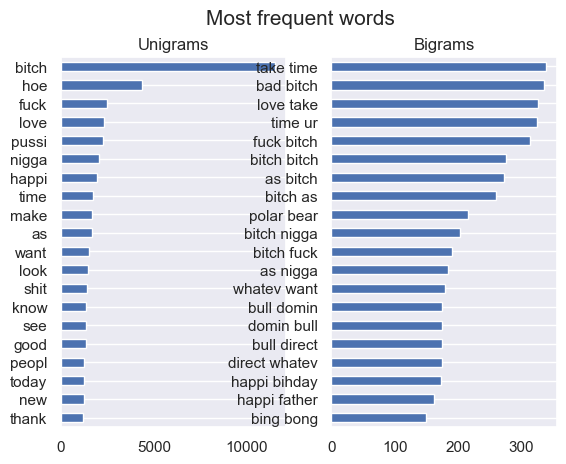

Wall time: 1.98 s


In [ ]:
%%time

corpus = data["clean_tweet"]
lst_tokens = nltk.tokenize.word_tokenize(corpus.str.cat(sep=" "))
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.suptitle("Most frequent words", fontsize=15)
top =20   
## unigrams
dic_words_freq = nltk.FreqDist(lst_tokens)
dtf_uni = pd.DataFrame(dic_words_freq.most_common(),columns=["Word","Freq"])
dtf_uni.set_index("Word").iloc[:top,:].sort_values(by="Freq").plot(kind="barh",\
                        title="Unigrams",ax=ax[0],legend=False).grid(axis='x')
ax[0].set(ylabel=None)
    
# ## bigrams
dic_words_freq = nltk.FreqDist(nltk.ngrams(lst_tokens, 2))
dtf_bi = pd.DataFrame(dic_words_freq.most_common(),columns=["Word","Freq"])
dtf_bi["Word"] = dtf_bi["Word"].apply(lambda x: " ".join(string for string in x))
dtf_bi.set_index("Word").iloc[:top,:].sort_values(by="Freq").plot(kind="barh", title="Bigrams", ax=ax[1],\
                  legend=False).grid(axis='x')
ax[1].set(ylabel=None)
plt.show()



### 3.4 Word Map

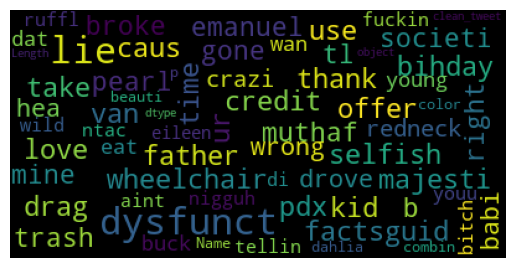

Wall time: 423 ms


In [ ]:
%%time

import wordcloud

wc = wordcloud.WordCloud(background_color='black', max_words=3000, 
                         max_font_size=30)
wc = wc.generate(str(corpus))
fig = plt.figure(num=1)
plt.axis('off')
plt.imshow(wc, cmap=None)
plt.savefig('figure3.png')
plt.show()
plt.close()

### 3.5 Topic Modelling

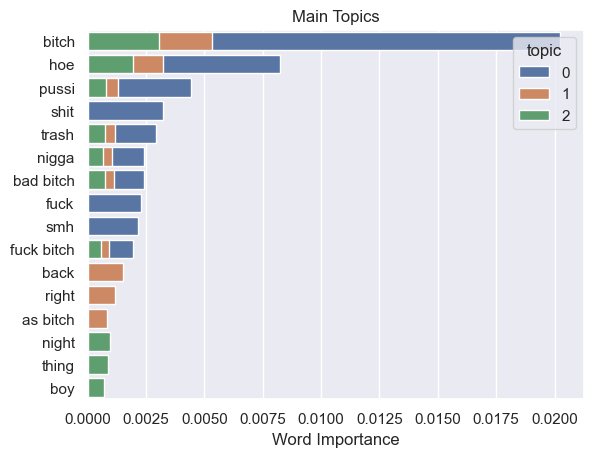

Wall time: 5min 49s


In [ ]:
%%time

corpus = data["clean_tweet"]

## pre-process corpus
lst_corpus = []
for string in corpus:
    lst_words = string.split()
    lst_grams = [" ".join(lst_words[i:i + 2]) for i in range(0, 
                     len(lst_words), 2)]
    lst_corpus.append(lst_grams)
## map words to an id
id2word = gensim.corpora.Dictionary(lst_corpus)
## create dictionary word:freq
dic_corpus = [id2word.doc2bow(word) for word in lst_corpus] 
## train LDA
lda_model = gensim.models.ldamodel.LdaModel(corpus=dic_corpus, id2word=id2word, 
                                            num_topics=3, random_state=123, 
                                            update_every=1, chunksize=100,
                                            passes=10, alpha='auto',
                                            per_word_topics=True)
   
## output
lst_dics = []
for i in range(0,3):
    lst_tuples = lda_model.get_topic_terms(i)
    for tupla in lst_tuples:
        lst_dics.append({"topic":i, "id":tupla[0], 
                         "word":id2word[tupla[0]], 
                         "weight":tupla[1]})
df_topics = pd.DataFrame(lst_dics, 
                         columns=['topic','id','word','weight'])
    
## plot
fig, ax = plt.subplots()
sns.barplot(y="word", x="weight", hue="topic", data=df_topics, dodge=False, ax=ax).set_title('Main Topics')
ax.set(ylabel="", xlabel="Word Importance")
plt.show()

### 5. Further Text Analysis

#### There are several length measures for text data. I will give some examples:

1. word count: counts the number of tokens in the text (separated by a space)
2. character count: sum the number of characters of each token
3. sentence count: count the number of sentences (separated by a period)
4. average word length: sum of words length divided by the number of words (character count/word count)
5. average sentence length: sum of sentences length divided by the number of sentences (word count/sentence count)

In [ ]:
%%time

data['word_count'] = data["clean_tweet"].apply(lambda x: len(str(x).split(" ")))
data['char_count'] = data["clean_tweet"].apply(lambda x: sum(len(word) for word in str(x).split(" ")))
data['sentence_count'] = data["clean_tweet"].apply(lambda x: len(str(x).split(".")))

data['avg_word_length'] = data['char_count'] / data['word_count']
data['avg_sentence_lenght'] = data['word_count'] / data['sentence_count']

Wall time: 178 ms


In [ ]:
data[['sen_score_vader','word_count']].corr()

,sen_score_vader,word_count
sen_score_vader,1.000000,-0.142757
word_count,-0.142757,1.000000


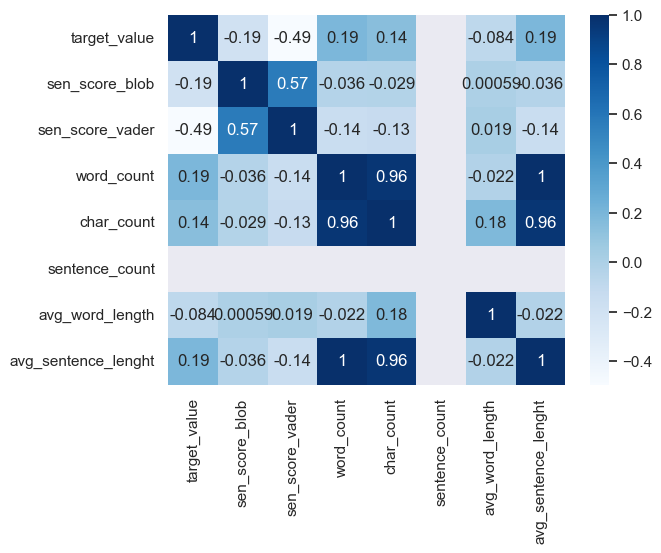

Wall time: 466 ms


In [ ]:
%%time

sns.heatmap(data.corr(),annot=True,cmap='Blues')
plt.show()

### 4.Feature Engineering- Use Transfer Learning (Glove)


In [ ]:
%%time

data= data.sample(35000)

# Count vectorization of text
from sklearn.feature_extraction.text import CountVectorizer

# Ticket Data
corpus = data['clean_tweet'].values

# Creating the vectorizer
vectorizer = CountVectorizer(stop_words='english')

# Converting the text to numeric data
X = vectorizer.fit_transform(corpus)

# print(vectorizer.get_feature_names())

# Preparing Data frame For machine learning
CountVectorizedData=pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())
CountVectorizedData['label']=data['target_value']
print(CountVectorizedData.shape)
CountVectorizedData.head()

(35000, 18526)
Wall time: 49 s


,aa,aaa,aaaaaaaaand,aaaaaand,aaaaah,aaaaand,aaahh,aaahhhhh,aaand,aaawwwww,...,zulema,zulu,zuma,zx,zydeco,zz,zzz,zzzquil,zzzzzz,zzzzzzzz
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
%%time

import numpy as np
import gensim.downloader as api

# Load the GloVe word vectors
model = api.load("glove-wiki-gigaword-50")

# Define an empty dictionary to store the values
GloveWordVectors = {}

# Populate the dictionary with the GloVe word vectors
for word in model.key_to_index.keys():
    GloveWordVectors[word] = model.get_vector(word)

Wall time: 23.1 s


In [ ]:
# Checking the total number of words present
print(len(GloveWordVectors.keys()))

# Each word has a numeric representation of 50 numbers
print(GloveWordVectors['bye'].shape)

400000
(50,)


In [ ]:
# Creating the list of words which are present in the Document term matrix
WordsVocab=CountVectorizedData.columns

# Printing sample words
WordsVocab[0:10]

Index(['aa', 'aaa', 'aaaaaaaaand', 'aaaaaand', 'aaaaah', 'aaaaand', 'aaahh',
       'aaahhhhh', 'aaand', 'aaawwwww'],
      dtype='object')

In [ ]:
# Defining a function which takes text input and returns one vector for each sentence


def FunctionText2Vec(inpTextData):
    
    # Converting the text to numeric data
    X = vectorizer.transform(inpTextData)
    CountVecData=pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())
    
    # Creating empty dataframe to hold sentences
    W2Vec_Data=pd.DataFrame()
    
    # Looping through each row for the data
    for i in range(CountVecData.shape[0]):
    
        # initiating a sentence with all zeros
        Sentence = np.zeros(50)
 
        # the Glove model then storing its vector
        for word in WordsVocab[CountVecData.iloc[i, :]>=1]:
           
            #print(word)
            if word in GloveWordVectors.keys():    
                Sentence=Sentence+GloveWordVectors[word]
                
        # Appending the sentence to the dataframe
        W2Vec_Data=W2Vec_Data.append(pd.DataFrame([Sentence]))
        
    return(W2Vec_Data)

In [ ]:
NewTicket=["you bitch i will slap you"]

FunctionText2Vec(NewTicket)

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,-1.8922,-0.70733,-0.45629,-1.37226,-0.36364,1.17793,0.76514,-0.25443,-0.49643,1.13749,...,0.19491,0.87924,-0.32877,0.081322,0.01641,-1.30801,0.69337,-0.41729,0.37117,0.713911


In [ ]:
%%time

# Calling the function to convert all the text data to Glove Vectors
W2Vec_Data=FunctionText2Vec(data['clean_tweet'])


# Checking the new representation for sentences
W2Vec_Data.shape

Wall time: 4min 16s


(35000, 50)

In [ ]:
W2Vec_Data.sample(2)

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0.785980,0.765546,-1.271280,-0.465598,0.68078,-1.844460,-0.269170,-1.34872,-0.91221,1.94727,...,-0.304126,0.095836,-0.303330,1.47938,1.393420,0.44986,0.179690,0.808270,-0.307014,-0.104180
0,-0.411715,-1.150821,-1.039655,-0.892280,-0.13090,0.117169,1.024894,-2.17253,1.14420,0.03280,...,0.073729,0.269870,-0.214944,2.88787,2.038273,-0.71535,1.583293,-0.938514,2.792120,1.604024


In [ ]:
# Adding the target variable
W2Vec_Data.reset_index(inplace=True, drop=True)
W2Vec_Data['target_value']=data['target_value'].values

# Assigning to DataForML variable
DataForML=W2Vec_Data
DataForML.head()

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,target_value
0,-0.412977,0.353330,0.643408,1.139214,-1.370120,-1.479750,0.464890,-0.452718,-0.204010,1.124237,...,-0.485400,0.914380,-1.11020,1.732172,0.960270,1.46775,0.113310,0.369430,1.337215,0
1,-1.318980,-0.625330,-0.422890,0.289510,-0.422770,-0.685490,1.901790,-0.607080,0.093850,0.972940,...,-0.250599,-1.220500,-1.08186,1.088610,-0.990074,0.51212,-2.052220,0.283790,1.135810,1
2,0.921680,2.134040,1.391100,1.779030,-0.274074,0.392600,0.228860,-1.974340,0.255980,-1.130760,...,1.187296,-0.126860,-0.05729,1.069950,-0.705420,0.26211,-2.640770,1.608780,-0.265520,0
3,-0.384998,1.511730,-0.487609,-0.197256,0.106580,0.163287,-1.401250,-0.253370,0.410190,-0.455640,...,-0.558035,-0.382024,-0.28486,0.087072,0.457383,-1.71308,-0.187431,-0.491964,1.247480,0
4,-0.158350,-0.350261,3.075011,0.355906,-0.367050,-3.219040,-1.208825,-0.428620,-0.412633,-0.803184,...,1.230235,-3.177186,-0.94921,3.166470,0.417390,3.15496,2.134230,4.185950,2.119190,0


In [ ]:
### Saving the data as csv
DataForML.to_csv('Data.csv',index=False)

**Data Split**

In [ ]:
%%time

TargetVariable=DataForML.columns[-1]
Predictors=DataForML.columns[:-1]

X=DataForML[Predictors].values
y=DataForML[TargetVariable].values

# Split the data into training and testing set
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=428)

# Sanity check for the sampled data
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(28000, 50)
(28000,)
(7000, 50)
(7000,)
Wall time: 102 ms


#### Function to Measure Performance

In [ ]:
%%time

from sklearn.metrics import accuracy_score, roc_auc_score,roc_curve , plot_confusion_matrix,precision_score, \
recall_score, f1_score,average_precision_score, matthews_corrcoef, log_loss, mean_squared_error


def modelPerfomanceMetrics(modelName,y_test,predicted_prob_test,predicted_prob_train,predicted,results=None):

    # Measures 1
    auc_test= roc_auc_score(y_test,predicted_prob_test)
    auc_train= roc_auc_score(y_train,predicted_prob_train)
    accuracy_score2=accuracy_score(y_test,predicted)
 
    # Print the scores
    print("------" + modelName.upper() + " METRICS-----\n")
    print(f'AUC TEST: {auc_test}\nAUC TRAIN :{auc_train}\nACCURANCY SCORE: {accuracy_score2}')

    # confusion matrix
    cm= confusion_matrix(y_test,predicted)
    print(cm)
    print(classification_report(y_test,predicted))
    
    
     # Draw Roc Curve
    fpr1 ,tpr1 , thresholds1 =roc_curve(y_test,predicted_prob_test)
    auc2=roc_auc_score(y_test,predicted_prob_test)
    plt.plot(fpr1,tpr1,color='r',label=f'ROC AREA {round(auc2,3)}')

    plt.plot([0, 1], [0, 1],'g--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('1-Specificity(False Positive Rate)')
    plt.ylabel('Sensitivity(True Positive Rate)')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show() 

Wall time: 2.52 ms


## <u>__Model Training__ | __Model Tuning__ | __Model Evaluation__</u>


### 1.Logistics Regression Model

------LOGISTIC_MODEL METRICS-----

AUC TEST: 0.898358551388727
AUC TRAIN :0.8982059512546735
ACCURANCY SCORE: 0.8455714285714285
[[3707  396]
 [ 685 2212]]
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      4103
           1       0.85      0.76      0.80      2897

    accuracy                           0.85      7000
   macro avg       0.85      0.83      0.84      7000
weighted avg       0.85      0.85      0.84      7000



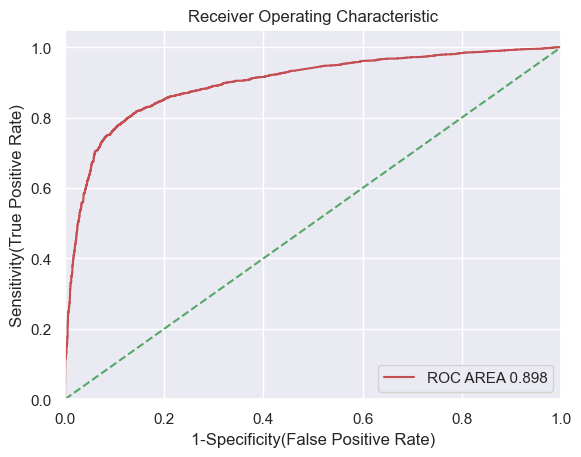

Wall time: 1.33 s


In [ ]:
%%time

from sklearn.linear_model import  LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score , confusion_matrix, classification_report ,roc_curve

lr_model=LogisticRegression(penalty='l2',C=0.01).fit(x_train, y_train)
predicted= lr_model.predict(x_test)

lr_model.name='LogisticRegression'

predicted_prob= lr_model.predict_proba(x_test)
predicted_prob=predicted_prob[:,1]

predicted_prob2= lr_model.predict_proba(x_train)
predicted_prob2=predicted_prob2[:,1]

modelPerfomanceMetrics('logistic_model',y_test,predicted_prob,predicted_prob2,predicted,results=None)

**Investigate the paramater C in imporve accurancy**

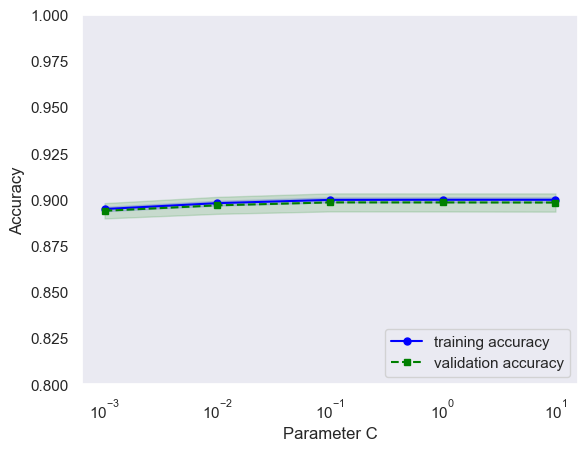

The optimal value of the hyperparameter is 0.1
Wall time: 10.6 s


In [ ]:
%%time

from sklearn.model_selection import validation_curve
from sklearn.linear_model import LogisticRegression

# Create an instance of the model
model = lr_model

# Define the hyperparameter you want to vary and its range of values
param_name = 'C'
param_range = [0.001, 0.01, 0.1, 1, 10]
scoring = 'roc_auc'

# Generate the validation curve
train_scores, test_scores = validation_curve(
    model, x_train, y_train, param_name=param_name, param_range=param_range,
    scoring=scoring, cv=5)

import matplotlib.pyplot as plt

# Compute the mean and standard deviation of the score on the training set
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Compute the mean and standard deviation of the score on the test set
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the validation curve
plt.plot(param_range, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
plt.fill_between(param_range, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(param_range, test_mean, color='green', marker='s', linestyle='--', markersize=5, label='validation accuracy')
plt.fill_between(param_range, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.0])
plt.show()

# Find the optimal value of the hyperparameter
index = np.argmax(test_mean)
optimal_param = param_range[index]
print(f"The optimal value of the hyperparameter is {optimal_param}")

**Retrain the Logistics regression with new paramaters C**

------LOGISTIC_MODEL METRICS-----

AUC TEST: 0.9003419120235907
AUC TRAIN :0.8996853584991376
ACCURANCY SCORE: 0.8478571428571429
[[3713  390]
 [ 675 2222]]
              precision    recall  f1-score   support

           0       0.85      0.90      0.87      4103
           1       0.85      0.77      0.81      2897

    accuracy                           0.85      7000
   macro avg       0.85      0.84      0.84      7000
weighted avg       0.85      0.85      0.85      7000



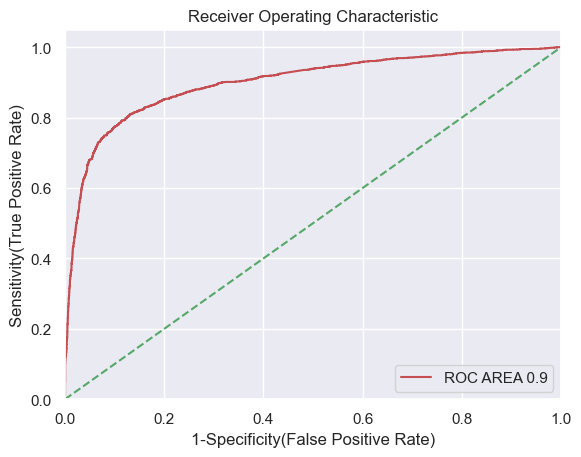

Wall time: 865 ms


In [ ]:
%%time

from sklearn.linear_model import  LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score , confusion_matrix, classification_report ,roc_curve

lr_model=LogisticRegression(penalty='l2',C=1).fit(x_train, y_train)
predicted= lr_model.predict(x_test)

lr_model.name='LogisticRegression'

predicted_prob= lr_model.predict_proba(x_test)
predicted_prob=predicted_prob[:,1]

predicted_prob2= lr_model.predict_proba(x_train)
predicted_prob2=predicted_prob2[:,1]

modelPerfomanceMetrics('logistic_model',y_test,predicted_prob,predicted_prob2,predicted)

### 2.KNN Model

------KNN METRICS-----

AUC TEST: 0.9094524149508459
AUC TRAIN :0.8996853584991376
ACCURANCY SCORE: 0.8568571428571429
[[3668  435]
 [ 567 2330]]
              precision    recall  f1-score   support

           0       0.87      0.89      0.88      4103
           1       0.84      0.80      0.82      2897

    accuracy                           0.86      7000
   macro avg       0.85      0.85      0.85      7000
weighted avg       0.86      0.86      0.86      7000



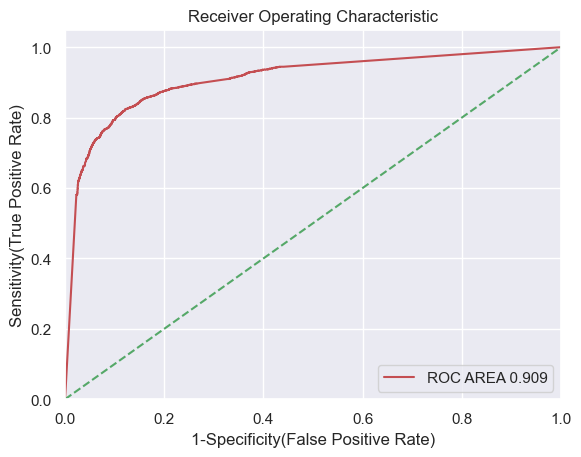

Wall time: 10.6 s


In [ ]:
%%time 

from sklearn.neighbors import KNeighborsClassifier
knnClf = KNeighborsClassifier(weights='distance',n_neighbors=5)

knnClf.name='KnnClassifier'

knnClf.fit(x_train, y_train)
predicted = knnClf.predict(x_test)

predicted_prob= knnClf.predict_proba(x_test)
predicted_prob=predicted_prob[:,1]

predicted_prob2= lr_model.predict_proba(x_train)
predicted_prob2=predicted_prob2[:,1]

modelPerfomanceMetrics('KNN',y_test,predicted_prob,predicted_prob2,predicted)

------KNN METRICS-----

AUC TEST: 0.9154744699211056
AUC TRAIN :0.8996853584991376
ACCURANCY SCORE: 0.8608571428571429
[[3695  408]
 [ 566 2331]]
              precision    recall  f1-score   support

           0       0.87      0.90      0.88      4103
           1       0.85      0.80      0.83      2897

    accuracy                           0.86      7000
   macro avg       0.86      0.85      0.86      7000
weighted avg       0.86      0.86      0.86      7000



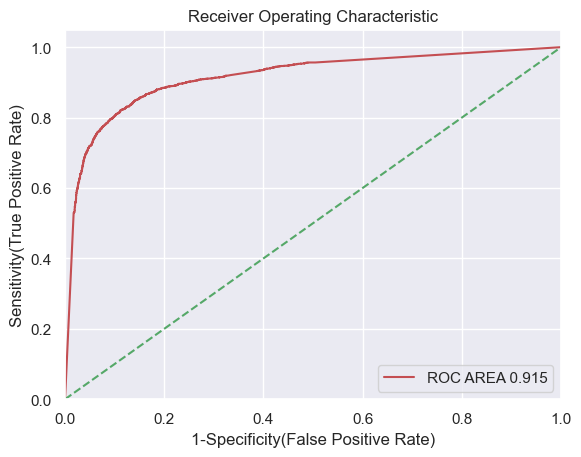

Wall time: 10.6 s


In [ ]:
%%time 

from sklearn.neighbors import KNeighborsClassifier
knnClf = KNeighborsClassifier(metric='minkowski',weights='distance',n_neighbors=7)
knnClf.name='KnnClassifier'

knnClf.fit(x_train, y_train)
predicted = knnClf.predict(x_test)

predicted_prob= knnClf.predict_proba(x_test)
predicted_prob=predicted_prob[:,1]

predicted_prob2= lr_model.predict_proba(x_train)
predicted_prob2=predicted_prob2[:,1]

modelPerfomanceMetrics('KNN',y_test,predicted_prob,predicted_prob2,predicted)

### 3.Decision Classifiers Model

------DCT METRICS-----

AUC TEST: 0.8387197173641687
AUC TRAIN :0.8480436614646557
ACCURANCY SCORE: 0.785
[[3628  475]
 [1030 1867]]
              precision    recall  f1-score   support

           0       0.78      0.88      0.83      4103
           1       0.80      0.64      0.71      2897

    accuracy                           0.79      7000
   macro avg       0.79      0.76      0.77      7000
weighted avg       0.79      0.79      0.78      7000



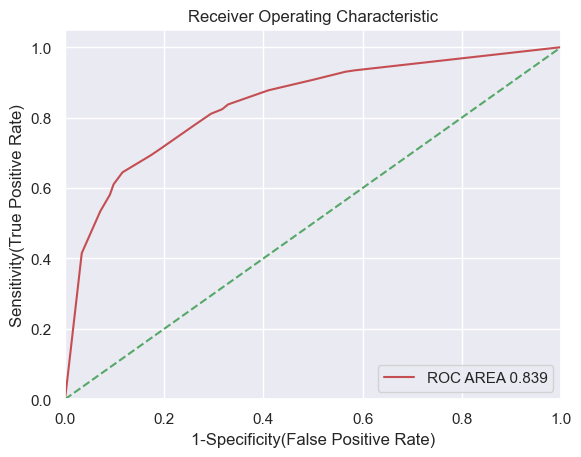

Wall time: 1.37 s


In [ ]:
%%time
from sklearn.tree import DecisionTreeClassifier

dtClassifier = DecisionTreeClassifier(random_state=112,max_depth=4,criterion='gini')
dtClassifier.name='DecisionTree'
dtClassifier.fit(x_train, y_train)
predicted = dtClassifier.predict(x_test)

predicted_prob= dtClassifier.predict_proba(x_test)
predicted_prob= predicted_prob[:,1]

predicted_prob2= dtClassifier.predict_proba(x_train)
predicted_prob2= predicted_prob2[:,1]

modelPerfomanceMetrics('DCT',y_test,predicted_prob,predicted_prob2,predicted)


**Investigate the max depth of trees to improve the Accurancy**

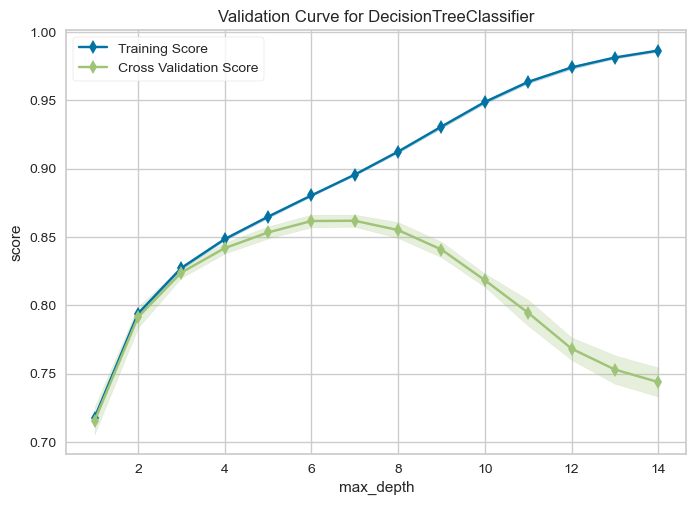

ValidationCurve(ax=<AxesSubplot:title={'center':'Validation Curve for DecisionTreeClassifier'}, xlabel='max_depth', ylabel='score'>,
                cv=10,
                estimator=DecisionTreeClassifier(max_depth=4, random_state=112),
                n_jobs=-1, param_name='max_depth',
                param_range=array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
                scoring='roc_auc')
Wall time: 1min 3s


In [ ]:
%%time
# Investigating the depth of the trees

from yellowbrick.model_selection import validation_curve 

# Plot the validation curve
print(validation_curve(dtClassifier, x_train, y_train, 
                       param_name="max_depth", n_jobs=-1,
                       param_range=np.arange(1, 15), 
                       cv=10, scoring="roc_auc"))

Investigate the min_sample leaf of trees to improve the Accurancy

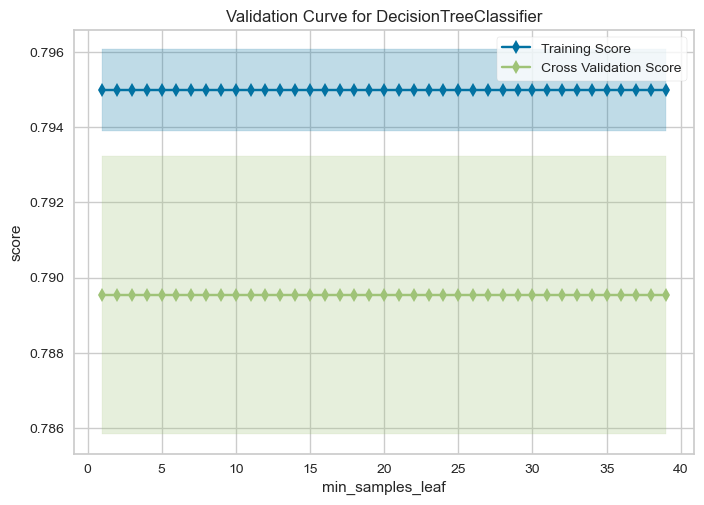

ValidationCurve(ax=<AxesSubplot:title={'center':'Validation Curve for DecisionTreeClassifier'}, xlabel='min_samples_leaf', ylabel='score'>,
                cv=5,
                estimator=DecisionTreeClassifier(max_depth=4, random_state=112),
                n_jobs=-1, param_name='min_samples_leaf',
                param_range=array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39]),
                scoring='accuracy')
Wall time: 35.7 s


In [ ]:
%%time
# Investigate the min_sample leaf


from yellowbrick.model_selection import validation_curve 

# Plot the validation curve
print(validation_curve(dtClassifier, x_train, y_train, 
                       param_name="min_samples_leaf", n_jobs=-1,
                       param_range=np.arange(1, 40), 
                       cv=5, scoring="accuracy"))

**Retrain the decision classifier with new parameters**

------DCT METRICS-----

AUC TEST: 0.855129281882112
AUC TRAIN :0.8793426953371335
ACCURANCY SCORE: 0.7985714285714286
[[3593  510]
 [ 900 1997]]
              precision    recall  f1-score   support

           0       0.80      0.88      0.84      4103
           1       0.80      0.69      0.74      2897

    accuracy                           0.80      7000
   macro avg       0.80      0.78      0.79      7000
weighted avg       0.80      0.80      0.80      7000



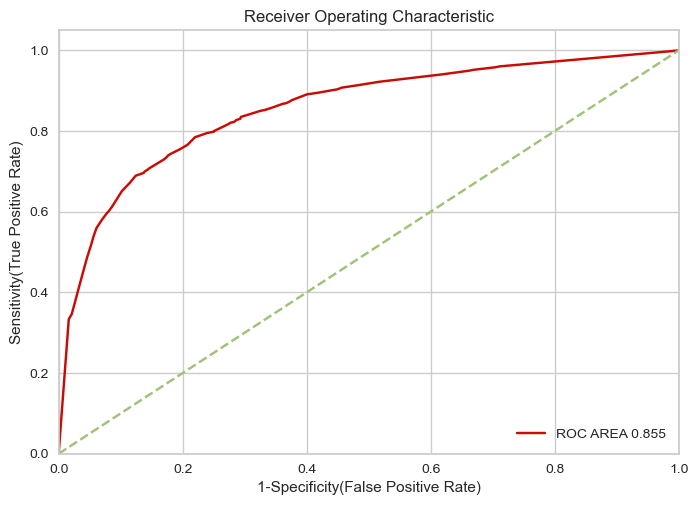

Wall time: 1.52 s


In [ ]:
%%time
from sklearn.tree import DecisionTreeClassifier

dtClassifier = DecisionTreeClassifier(random_state=148,max_depth=6,criterion='gini')
dtClassifier.name='DecisionTree'
dtClassifier.fit(x_train, y_train)
predicted = dtClassifier.predict(x_test)

predicted_prob= dtClassifier.predict_proba(x_test)
predicted_prob= predicted_prob[:,1]

predicted_prob2= dtClassifier.predict_proba(x_train)
predicted_prob2= predicted_prob2[:,1]

modelPerfomanceMetrics('DCT',y_test,predicted_prob,predicted_prob2,predicted)


### 4.Support Vector Machine Model

------SVM METRICS-----

AUC TEST: 0.8989787985268195
AUC TRAIN :0.8984709055500641
ACCURANCY SCORE: 0.8498571428571429
[[3722  381]
 [ 670 2227]]
              precision    recall  f1-score   support

           0       0.85      0.91      0.88      4103
           1       0.85      0.77      0.81      2897

    accuracy                           0.85      7000
   macro avg       0.85      0.84      0.84      7000
weighted avg       0.85      0.85      0.85      7000



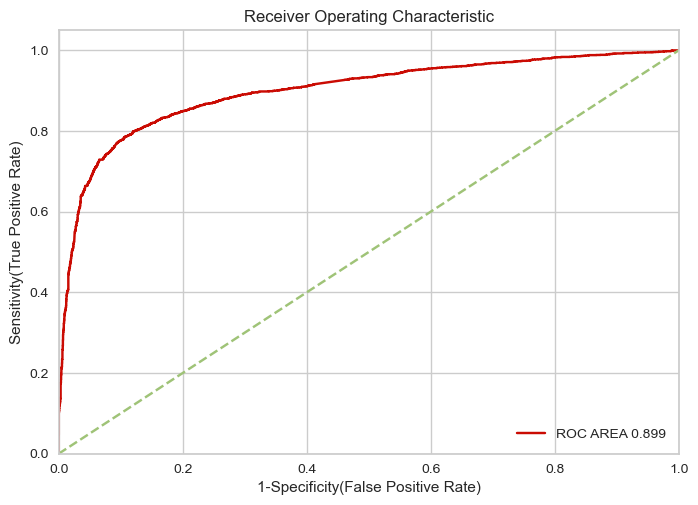

Wall time: 9min 47s


In [ ]:
%%time

from sklearn.svm import SVC

svmodel = SVC(C=0.1, kernel='linear', probability=True)
svmodel.fit(x_train, y_train)
svmodel.name='SVM'

predicted= svmodel.predict(x_test)

predicted_prob= svmodel.predict_proba(x_test)
predicted_prob= predicted_prob[:,1]

predicted_prob2= svmodel.predict_proba(x_train)
predicted_prob2= predicted_prob2[:,1]

modelPerfomanceMetrics('SVM',y_test,predicted_prob,predicted_prob2,predicted)

### 5. Light GM Model

------LGBM METRICS-----

AUC TEST: 0.9329730108996079
AUC TRAIN :0.9991438841962055
ACCURANCY SCORE: 0.8702857142857143
[[3781  322]
 [ 586 2311]]
              precision    recall  f1-score   support

           0       0.87      0.92      0.89      4103
           1       0.88      0.80      0.84      2897

    accuracy                           0.87      7000
   macro avg       0.87      0.86      0.86      7000
weighted avg       0.87      0.87      0.87      7000



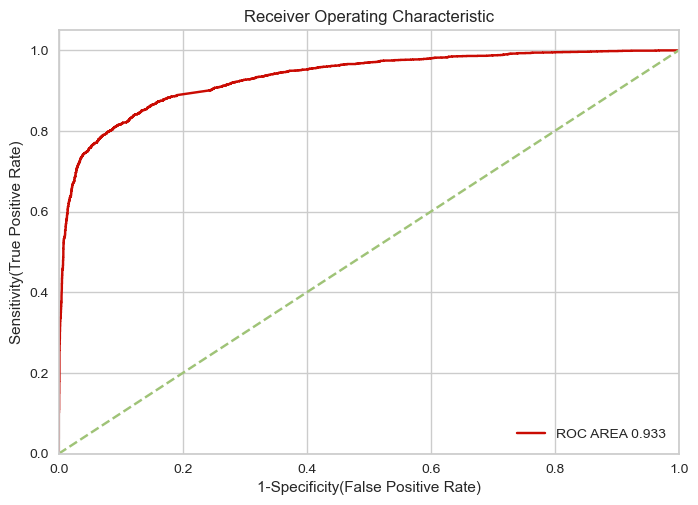

Wall time: 6.62 s


In [ ]:
%%time

import lightgbm as lgb

lgbm= lgb.LGBMClassifier(n_estimators=1000,max_depth=7)
lgbm.fit(x_train, y_train)

lgbm.name='LGBM'

predicted=lgbm.predict(x_test)

predicted_prob= lgbm.predict_proba(x_test)
predicted_prob= predicted_prob[:,1]

predicted_prob2= lgbm.predict_proba(x_train)
predicted_prob2= predicted_prob2[:,1]

modelPerfomanceMetrics('LGBM',y_test,predicted_prob,predicted_prob2,predicted)

### 6. Random Forest Classifier Model

------RF METRICS-----

AUC TEST: 0.8711132756780422
AUC TRAIN :0.8780297788347744
ACCURANCY SCORE: 0.8072857142857143
[[3789  314]
 [1035 1862]]
              precision    recall  f1-score   support

           0       0.79      0.92      0.85      4103
           1       0.86      0.64      0.73      2897

    accuracy                           0.81      7000
   macro avg       0.82      0.78      0.79      7000
weighted avg       0.81      0.81      0.80      7000



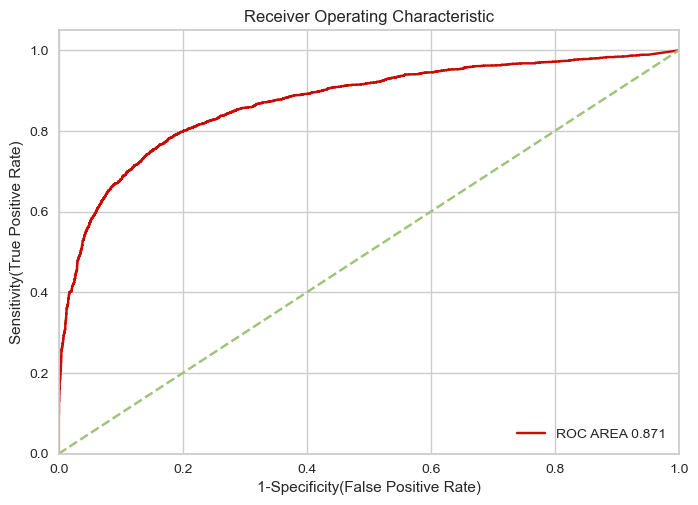

Wall time: 1min 45s


In [ ]:
%%time

from sklearn.ensemble import RandomForestClassifier

rf_random = RandomForestClassifier(n_estimators = 1500,
                           bootstrap = True,
                           max_features='auto', 
                                   max_depth=3,
                           random_state = 42)

rf_random.name='RandomForestClassifier'

rf_random.fit(x_train, y_train)

predicted= rf_random.predict(x_test)

predicted_prob= rf_random.predict_proba(x_test)
predicted_prob= predicted_prob[:,1]

predicted_prob2= rf_random.predict_proba(x_train)
predicted_prob2= predicted_prob2[:,1]

modelPerfomanceMetrics('RF',y_test,predicted_prob,predicted_prob2,predicted)

### 7. XGboost Model

------XGBOOST METRICS-----

AUC TEST: 0.9222584045905944
AUC TRAIN :0.9564551735122424
ACCURANCY SCORE: 0.8072857142857143
[[3789  314]
 [1035 1862]]
              precision    recall  f1-score   support

           0       0.79      0.92      0.85      4103
           1       0.86      0.64      0.73      2897

    accuracy                           0.81      7000
   macro avg       0.82      0.78      0.79      7000
weighted avg       0.81      0.81      0.80      7000



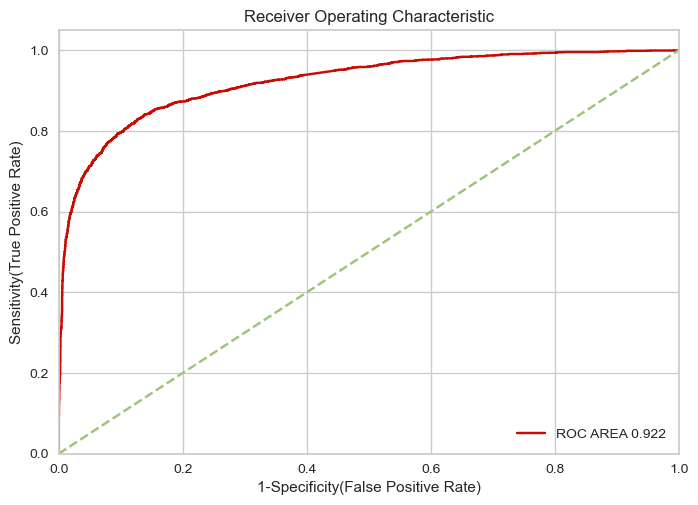

In [ ]:
import xgboost as xgb


# Initialize the XGBoost classifier

xgb_clf = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=5)

xgb_clf.name='XGBBOOST'

# Fit the XGBoost classifier to the training data
xgb_clf.fit(x_train, y_train)

predicted_prob= xgb_clf.predict_proba(x_test)
predicted_prob= predicted_prob[:,1]

predicted_prob2= xgb_clf.predict_proba(x_train)
predicted_prob2= predicted_prob2[:,1]

modelPerfomanceMetrics('XGBOOST',y_test,predicted_prob,predicted_prob2,predicted)


### 8.Catboost Model

0:	learn: 0.6451448	total: 181ms	remaining: 17.9s
1:	learn: 0.6050154	total: 209ms	remaining: 10.2s
2:	learn: 0.5729641	total: 231ms	remaining: 7.47s
3:	learn: 0.5473083	total: 251ms	remaining: 6.02s
4:	learn: 0.5277168	total: 271ms	remaining: 5.14s
5:	learn: 0.5102713	total: 292ms	remaining: 4.57s
6:	learn: 0.4956722	total: 312ms	remaining: 4.15s
7:	learn: 0.4831888	total: 331ms	remaining: 3.8s
8:	learn: 0.4731497	total: 350ms	remaining: 3.54s
9:	learn: 0.4638539	total: 368ms	remaining: 3.31s
10:	learn: 0.4561991	total: 388ms	remaining: 3.14s
11:	learn: 0.4493055	total: 409ms	remaining: 3s
12:	learn: 0.4432686	total: 428ms	remaining: 2.86s
13:	learn: 0.4372859	total: 448ms	remaining: 2.75s
14:	learn: 0.4331128	total: 466ms	remaining: 2.64s
15:	learn: 0.4287550	total: 485ms	remaining: 2.55s
16:	learn: 0.4251299	total: 506ms	remaining: 2.47s
17:	learn: 0.4216537	total: 527ms	remaining: 2.4s
18:	learn: 0.4187540	total: 548ms	remaining: 2.33s
19:	learn: 0.4157468	total: 569ms	remaining: 2

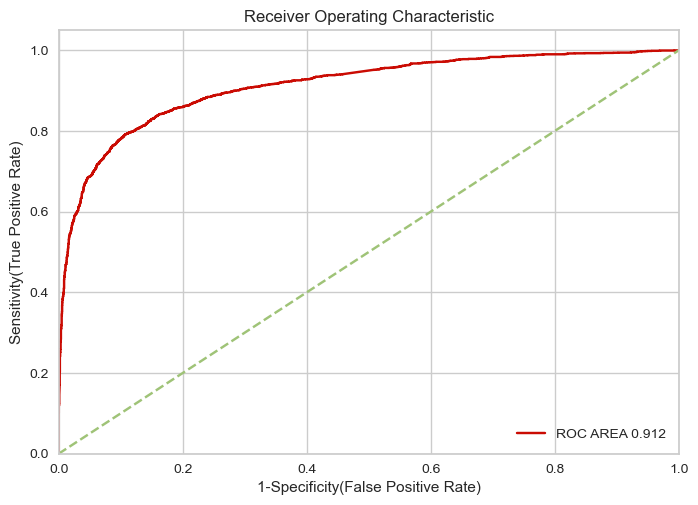

In [ ]:
import catboost as cb


# Initialize the CatBoost classifier
catboost_clf = cb.CatBoostClassifier(iterations=100, learning_rate=0.1, depth=5)

# Fit the CatBoost classifier to the training data
catboost_clf.fit(x_train, y_train)

catboost_clf.name='CATBOOST'

predicted_prob= catboost_clf.predict_proba(x_test)
predicted_prob= predicted_prob[:,1]

predicted_prob2= catboost_clf.predict_proba(x_train)
predicted_prob2= predicted_prob2[:,1]

modelPerfomanceMetrics('Catboost',y_test,predicted_prob,predicted_prob2,predicted)



### 9. Adaboost Models

------ADABOOST METRICS-----

AUC TEST: 0.8939579305442669
AUC TRAIN :0.8998344084174392
ACCURANCY SCORE: 0.8072857142857143
[[3789  314]
 [1035 1862]]
              precision    recall  f1-score   support

           0       0.79      0.92      0.85      4103
           1       0.86      0.64      0.73      2897

    accuracy                           0.81      7000
   macro avg       0.82      0.78      0.79      7000
weighted avg       0.81      0.81      0.80      7000



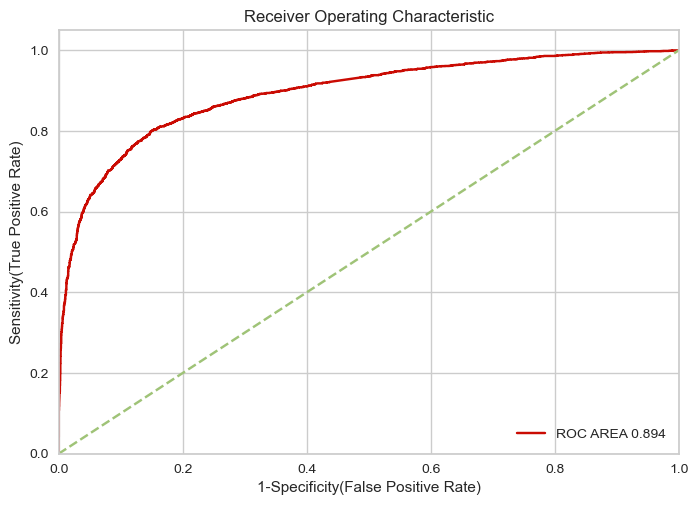

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier


# Initialize the base classifier
base_clf = DecisionTreeClassifier(max_depth=1)

# Initialize the AdaBoostClassifier
adaboost_clf = AdaBoostClassifier(base_estimator=base_clf, n_estimators=50, learning_rate=1.0)

# Fit the AdaBoostClassifier to the training data
adaboost_clf.fit(x_train, y_train)

adaboost_clf.name='AdaboostClassifier'


predicted_prob= adaboost_clf.predict_proba(x_test)
predicted_prob= predicted_prob[:,1]

predicted_prob2= adaboost_clf.predict_proba(x_train)
predicted_prob2= predicted_prob2[:,1]

modelPerfomanceMetrics('Adaboost',y_test,predicted_prob,predicted_prob2,predicted)


### 10. Stacking Ensemble Approach

------STACKINGENSEMBLE METRICS-----

AUC TEST: 0.9351056178448109
AUC TRAIN :0.9915129309006099
ACCURANCY SCORE: 0.8072857142857143
[[3789  314]
 [1035 1862]]
              precision    recall  f1-score   support

           0       0.79      0.92      0.85      4103
           1       0.86      0.64      0.73      2897

    accuracy                           0.81      7000
   macro avg       0.82      0.78      0.79      7000
weighted avg       0.81      0.81      0.80      7000



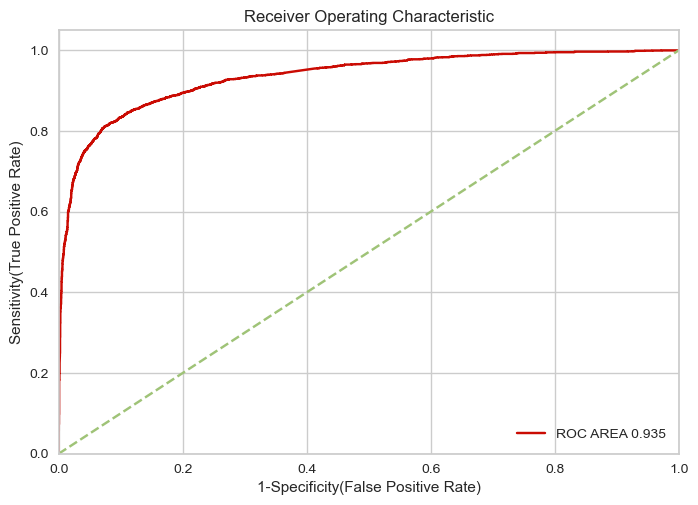

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.ensemble import StackingClassifier


# Define the base models to use in the stacking ensemble
knn = KNeighborsClassifier(n_neighbors=3)
svm = SVC(probability=True)
rf = RandomForestClassifier()

# Define the meta-model to use in the stacking ensemble
meta_model = LogisticRegression()

# Define the stacking ensemble
stacking_ensemble = StackingClassifier(estimators=[('knn', knn), ('svm', svm), ('rf', rf)], final_estimator=meta_model)


# Fit the stacking ensemble to the training data
stacking_ensemble.fit(x_train, y_train)

stacking_ensemble.name='Stacking Ensemble'

predicted_prob= stacking_ensemble.predict_proba(x_test)
predicted_prob= predicted_prob[:,1]

predicted_prob2= stacking_ensemble.predict_proba(x_train)
predicted_prob2= predicted_prob2[:,1]

modelPerfomanceMetrics('StackingEnsemble',y_test,predicted_prob,predicted_prob2,predicted)

### 11.Voting Ensemble Approach

------VOTING ENSEMBLE METRICS-----

AUC TEST: 0.9274556928171048
AUC TRAIN :0.9903889495663539
ACCURANCY SCORE: 0.8072857142857143
[[3789  314]
 [1035 1862]]
              precision    recall  f1-score   support

           0       0.79      0.92      0.85      4103
           1       0.86      0.64      0.73      2897

    accuracy                           0.81      7000
   macro avg       0.82      0.78      0.79      7000
weighted avg       0.81      0.81      0.80      7000



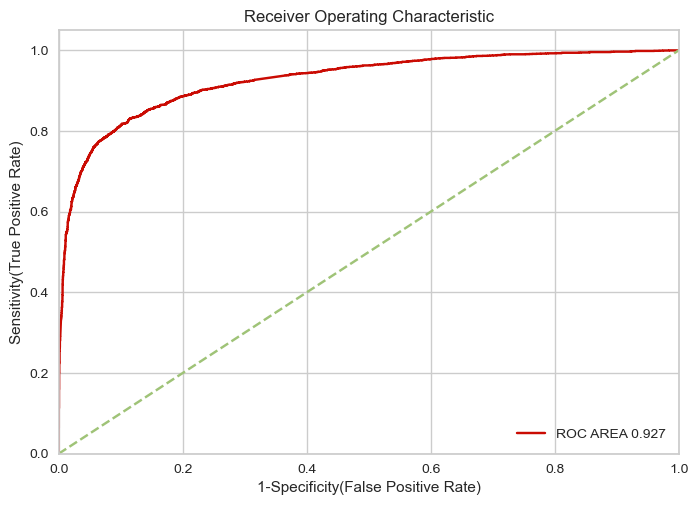

In [ ]:
from sklearn.ensemble import VotingClassifier

# Define the base models to use in the voting ensemble
knn = KNeighborsClassifier(n_neighbors=3)
logreg = LogisticRegression()
rf = RandomForestClassifier()

# Define the voting ensemble
voting_ensemble = VotingClassifier(estimators=[('knn', knn), ('logreg', logreg), ('rf', rf)], voting='soft')

voting_ensemble.name='VotingClassifier'

# Fit the voting ensemble to the training data
voting_ensemble.fit(x_train, y_train)

# Evaluate the performance of the voting ensemble on the test data
predicted_prob= voting_ensemble.predict_proba(x_test)
predicted_prob= predicted_prob[:,1]

predicted_prob2= voting_ensemble.predict_proba(x_train)
predicted_prob2= predicted_prob2[:,1]

modelPerfomanceMetrics('Voting Ensemble',y_test,predicted_prob,predicted_prob2,predicted)

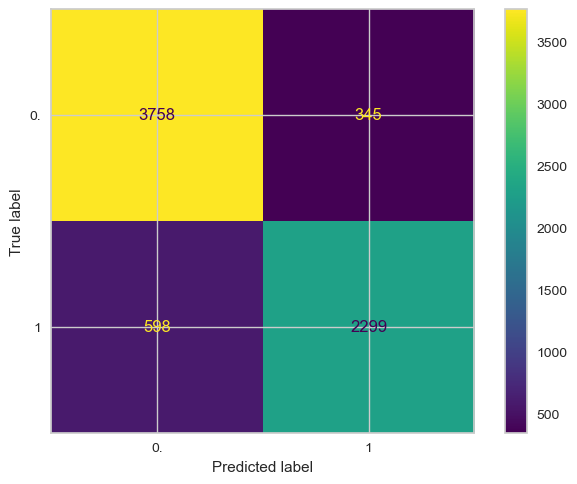

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_preds=voting_ensemble.predict(x_test)
cm = confusion_matrix(y_test, y_preds)
cmd = ConfusionMatrixDisplay(cm, display_labels=['0.','1'])
cmd.plot()

## Model Performance

In [ ]:
# Function to score and store

def store_metrics(y_true, y_pred,y_train,y_predict_test,y_predict_train, model_name):
    
    # Metrics 1
    
    precision = precision_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred)
    conf_matrix = confusion_matrix(y_true, y_pred)
    auprc = average_precision_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    
    if len(np.unique(y_true)) > 2:
        log_loss_value = np.nan
        rmse = np.nan
    else:
        log_loss_value = log_loss(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        
    #Metric Two
    auc_test= roc_auc_score(y_test,y_predict_test)
    auc_train= roc_auc_score(y_train,y_predict_train)
    
    
    
    return pd.DataFrame({
        "Model": [model_name],
        "Precision": [precision],
        "Recall": [recall],
        "F1_Score": [f1],
        "Accuracy": [accuracy],
        "AUC": [auc],
        "AUC Test": [auc_test],
        "AUC Train": [auc_train],
        "Confusion_Matrix": [conf_matrix],
        "AUPRC": [auprc],
        "MCC": [mcc],
        "Log_Loss": [log_loss_value],
        "RMSE": [rmse]
    })

In [ ]:
models=[lr_model,knnClf,dtClassifier,lgbm,rf_random,xgb_clf,catboost_clf,adaboost_clf,\
       voting_ensemble,stacking_ensemble,svmodel]

results = pd.DataFrame()
for model in models:
  
    y_pred= model.predict(x_test)
    
    y_predict_test= model.predict_proba(x_test)
    y_predict_test= y_predict_test[:,1]
    
    y_predict_train= model.predict_proba(x_train)
    y_predict_train= y_predict_train[:,1]
    
    model_results= store_metrics(y_test,y_pred,y_train,y_predict_test,y_predict_train, model.name)
    
    results=pd.concat([results,model_results],ignore_index=True)

In [ ]:
results

,Model,Precision,Recall,F1_Score,Accuracy,AUC,AUC Test,AUC Train,Confusion_Matrix,AUPRC,MCC,Log_Loss,RMSE
0,LogisticRegression,0.850689,0.767000,0.806680,0.847857,0.835974,0.900342,0.899685,"[[3713, 390], [675, 2222]]",0.748907,0.684291,5.254873,0.390055
1,KnnClassifier,0.851041,0.804625,0.827182,0.860857,0.852593,0.915474,0.999245,"[[3695, 408], [566, 2331]]",0.765626,0.711667,4.805871,0.373019
2,DecisionTree,0.796570,0.689334,0.739082,0.798571,0.782517,0.855129,0.879343,"[[3593, 510], [900, 1997]]",0.677674,0.580436,6.957155,0.448808
3,LGBM,0.877706,0.797722,0.835805,0.870286,0.859621,0.932973,0.999144,"[[3781, 322], [586, 2311]]",0.783880,0.731279,4.480209,0.360159
4,RandomForestClassifier,0.855699,0.642734,0.734082,0.807286,0.783102,0.871113,0.878030,"[[3789, 314], [1035, 1862]]",0.697844,0.602511,6.656151,0.438992
5,XGBBOOST,0.865872,0.777701,0.819422,0.858143,0.846321,0.922258,0.956455,"[[3754, 349], [644, 2253]]",0.765390,0.705915,4.899612,0.376639
6,CATBOOST,0.860700,0.763548,0.809219,0.851000,0.838148,0.912286,0.921833,"[[3745, 358], [685, 2212]]",0.755044,0.691024,5.146319,0.386005
7,AdaboostClassifier,0.815741,0.765620,0.789886,0.831429,0.821757,0.893958,0.899834,"[[3602, 501], [679, 2218]]",0.721547,0.650288,5.822308,0.410575
8,VotingClassifier,0.869516,0.793580,0.829814,0.865286,0.854747,0.927456,0.990389,"[[3758, 345], [598, 2299]]",0.775459,0.720775,4.652906,0.367034
9,Stacking Ensemble,0.886200,0.809113,0.845904,0.878000,0.867876,0.935106,0.991513,"[[3802, 301], [553, 2344]]",0.796036,0.747394,4.213765,0.349285


In [ ]:
# Export results

results.to_csv('performance.csv')

## reference

https://towardsdatascience.com/kagglers-guide-to-lightgbm-hyperparameter-tuning-with-optuna-in-2021-ed048d9838b5

https://thinkingneuron.com/how-to-classify-text-using-word2vec/

https://thinkingneuron.com/support-ticket-classification-using-tf-idf-vectorization/

https://thinkingneuron.com/sentiment-analysis-of-tweets-using-bert/

https://thinkingneuron.com/transfer-learning-with-glove/